In [2]:
import numpy as np
import pandas as pd
import pickle
import tqdm
import os, os.path
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_auc_score as auc
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from mlxtend.classifier import EnsembleVoteClassifier

import transforms as t
import classifiers as clsf

np.random.seed(69)

# Data Preprocessing

In [3]:
train_df0 = pd.read_csv('train.csv')
# Y0 are new labels (maybe smoothed or with regression), Y_c0 are original class labels
X0_df, Y_c0, Y0 = t.transform_df(train_df0, train=True, as_df=True, k=None)
X0 = X0_df.values
(N, d) = X0.shape

In [4]:
pars = t.get_pars_for_processing(X0)
process = lambda x: t.process_with_pars(x, pars)
X = process(X0)

# Ensembling from trained Models

In [13]:
# This model got a .85 auc and a .72 accuracy, but a .58 auc on the Kaggle,
# WTF, i don't get it.
model = 'to_ensemble/aws0_model.pkl'
with open(model, 'rb') as f:
        model = pickle.load(f)
        
print(auc(Y_c0, model.predict_proba(X)[:,1])) # Get auc on original labels
(clf.predict(X) == Y0).mean()

0.8519330053908346


0.7228738309868665

In [5]:
#model_names = ['gdb_k5_smoothing.pkl', 'adb_k4_smoothing.pkl', 'rf_k4_smoothing.pkl']

ens_dir = 'to_ensemble'
model_names = [os.path.join(ens_dir, n) for n in os.listdir(ens_dir) \
                                   if os.path.splitext(n)[1] == '.pkl']

models=[]
for n in model_names:
    with open(n, 'rb') as f:
        models.append(pickle.load(f))

#weights = np.array([0.3, 0.3, 0.4])
weights = np.array([auc(Y_c0, m.predict_proba(X0)[:,1]) for m in tqdm.tqdm_notebook(models)])
weights = list(weights / weights.sum()) # Has to be a list unfortunately

clf = EnsembleVoteClassifier(clfs=models,voting="soft",refit=False, weights=weights)
clf.named_clfs.keys()

dict_keys(['randomforestclassifier-1', 'adaboostclassifier', 'randomforestclassifier-2'])

# Final Fitting

In [6]:
pars = t.get_pars_for_processing(X0)
process = lambda x: t.process_with_pars(x, pars)
X = process(X0)
clf.fit(X, Y0);

### Save Model

In [7]:
#fName = datetime.today().strftime('%y%m%d_%H%M') + "_ensemble.pkl"
#
#with open(fName, 'wb') as f:
#    pickle.dump(clf, f)
#    
#with open(fName, 'rb') as f:
#    clf = pickle.load(f)

### Final train auc (on original labels)

In [8]:
auc(Y_c0, clf.predict_proba(X)[:,1]) # Get auc on original labels

0.8026353023069409

In [11]:
(clf.predict(X) == Y0).mean()

0.7228738309868665

# Get Predictions on Test Set

In [9]:
test_df0 = pd.read_csv('test.csv')
tX = t.transform_df(test_df0)
tX = process(tX)

output = clf.predict_proba(tX)[:, 1]
     
output_df = pd.DataFrame({'id':test_df0['id'], 'Predicted': output})
output_df.to_csv(f"submission_ens_{datetime.today().strftime('%y%m%d_%H%M')}.csv", index=False)

### Sanity checks on output

mean of train_labels: 0.3569583713157095
mean of train_preds: 0.41587164073809024


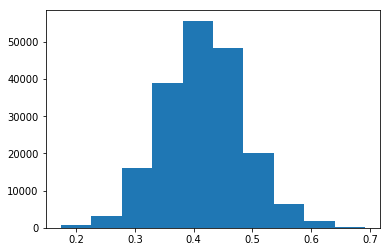

In [10]:
assert(np.all((0 <= output) & (output <= 1)))
print(f'mean of train_labels: {np.mean(Y_c0)}')
print(f'mean of train_preds: {np.mean(output)}')
plt.hist(output);